In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from User_Classes import UserClass
from Advertising_Environment import calculate_margin, calculate_price_index
from Clairvoyant import find_optimal_bid_for_class
from Advertising.GPTS_Learner import GPTS_Learner

import warnings
warnings.filterwarnings("ignore")

Optimal Prices:  [250, 200, 200]
Optimal Bids:  [0.9090909090909092, 0.8686868686868687, 0.8383838383838385]
Total Reward:  21225.882678658145


# Environment

In [32]:
#Environment
n_arms = 100
min_bid = 0.01
max_bid = 3.0
bids = np.linspace(min_bid, max_bid, n_arms)
sigma = 200

user = UserClass(name='C1')

#names = ['Young ', 'Old', 'Not Sporty', 'Sporty']

price = 200
T = 365
n_experiments = 1000

gpts_rewards_per_experiment = []

optimum_bid = find_optimal_bid_for_class(user.user_index, calculate_price_index(price))

In [3]:
def fun(user_class, bid, price):
    mean_per_bid = user_class.get_click_bids(bid) * (user_class.get_conversion_per_price(price) * calculate_margin(price)) - user_class.get_click_bids(bid) * user_class.get_cost_per_click(bid)    #sample_cost
    return mean_per_bid

In [4]:
class BiddingEnvironment:
    def __init__(self, bids, sigma, user_class, price, n_arms):
        self.bids = bids
        self.means = self.initialize_means(user_class=user_class, bids=bids, price=price)
        self.sigmas = np.ones(len(bids)) * sigma
        self.price = price
        self.n_arms = n_arms

    def initialize_means(self, user_class, bids, price):
        means = np.zeros(len(bids))
        for i in range(len(means)):
                means[i] = fun(user_class, bids[i], price)
        return means

    def round(self, pulled_arm):
        #print('Means')
        #print(self.means[pulled_arm])
        #print('Means Array')
        #print(self.means)
        return np.random.normal(self.means[pulled_arm], self.sigmas[pulled_arm])

# Experiment

In [34]:
for e in tqdm(range(0, 2)):
    env = BiddingEnvironment(bids=bids, sigma = sigma, user_class=user, price=price, n_arms=n_arms)
    gpts_learner = GPTS_Learner(n_arms, arms=bids)

    for t in tqdm(range(T)):
        #GP Thompson Sampling
        pulled_arm = gpts_learner.pull_arm()
        reward = env.round(pulled_arm)
        gpts_learner.update(pulled_arm, reward)

    gpts_rewards_per_experiment.append(gpts_learner.collected_rewards)

100%|██████████| 2/2 [03:16<00:00, 98.26s/it]


In [35]:
gpts_rewards_per_experiment[1]

array([13337.25547195, 13697.16032918, 13249.4891989 , 13575.12410062,
       13969.46458741, 13767.71449767, 13740.43538733, 13622.52437897,
       13789.49096584, 13860.16388976, 13790.29489743, 13611.09735093,
       14257.67362639, 13824.25561142, 13984.81250551, 13806.8094836 ,
        4141.04436607, 13441.23495838, 13752.83371604, 13723.37801936,
       13745.00181264,   475.48648912, 13563.55177582, 14056.19669455,
       13301.6191134 , 13294.64318544, 13825.25308392, 13633.46535055,
       13730.90767826, 13469.25549689, 13881.06597984, 13695.70683497,
       13722.30187994, 13727.06892994,  7828.13093791, 13586.99270795,
       13763.16832311, 13658.02210758, 13344.56434709, 13630.24068547,
       13871.11675532, 13939.25679629, 14150.22311674,  2530.64727222,
       13541.01966101, 13701.28381331, 13784.44490091,  9813.04669953,
       13704.40865524, 13275.11733718, 13911.90624024, 13867.27074043,
       10394.10220897, 14005.36048826, 13610.75705584, 13618.84256413,
      

In [36]:
optimum_bid

(0.9090909090909092, 14000.423137824051)

# Plot

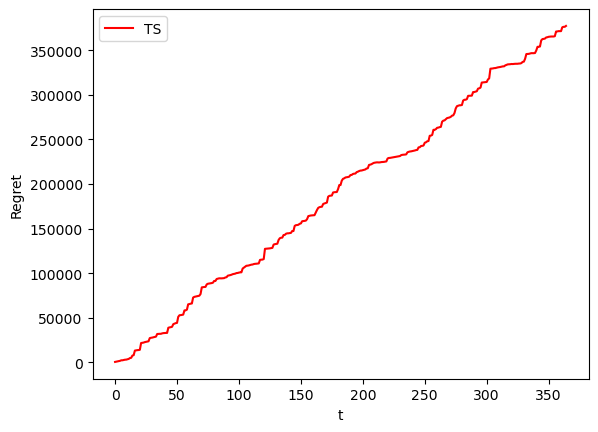

In [38]:
plt.figure(0)
plt.ylabel("Regret")
plt.xlabel("t")
plt.plot(np.cumsum(np.mean(optimum_bid[1] - gpts_rewards_per_experiment, axis=0)), 'r')
plt.legend(["TS", "UCB"])
plt.show()